In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
raw_df = pd.read_csv('SP.csv')
raw_df.head()

,date,time,price,volume
0,01/03/2000,08:30:34.000,1496.4,0
1,01/03/2000,08:30:36.000,1496.0,0
2,01/03/2000,08:30:37.000,1495.5,0
3,01/03/2000,08:30:46.000,1495.0,0
4,01/03/2000,08:30:53.000,1495.5,0


### Exploratory Data Analysis and Data Augmentation

In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13802502 entries, 0 to 13802501
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   date    object 
 1   time    object 
 2   price   float64
 3   volume  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 421.2+ MB


Check for null values

In [4]:
raw_df.isnull().sum()

date      0
time      0
price     0
volume    0
dtype: int64

In [5]:
df = raw_df.copy()

Convert date and time to datetime first

In [6]:
df['date'] = pd.to_datetime(df['date'], format="%m/%d/%Y")
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S.%f').dt.time

What is the date range of the dataset? It starts in January 3rd of 2000 and ends on December 31st of 2019, around 20 years of data.

In [7]:
np.min(df['date']), np.max(df['date'])

(Timestamp('2000-01-03 00:00:00'), Timestamp('2019-12-31 00:00:00'))

Let's look at summary statistics for price. It seems like the average price is $1247.14 with the max and min being $3253.50 and $665.70

In [8]:
pd.DataFrame({'summary_stats': df['price'].describe()})

,summary_stats
count,1.380250e+07
mean,1.247144e+03
std,2.645760e+02
min,6.657000e+02
25%,1.094500e+03
50%,1.223100e+03
75%,1.382400e+03
max,3.253500e+03


Plotting out the histogram of the prices, this data seems to be right-skewed.

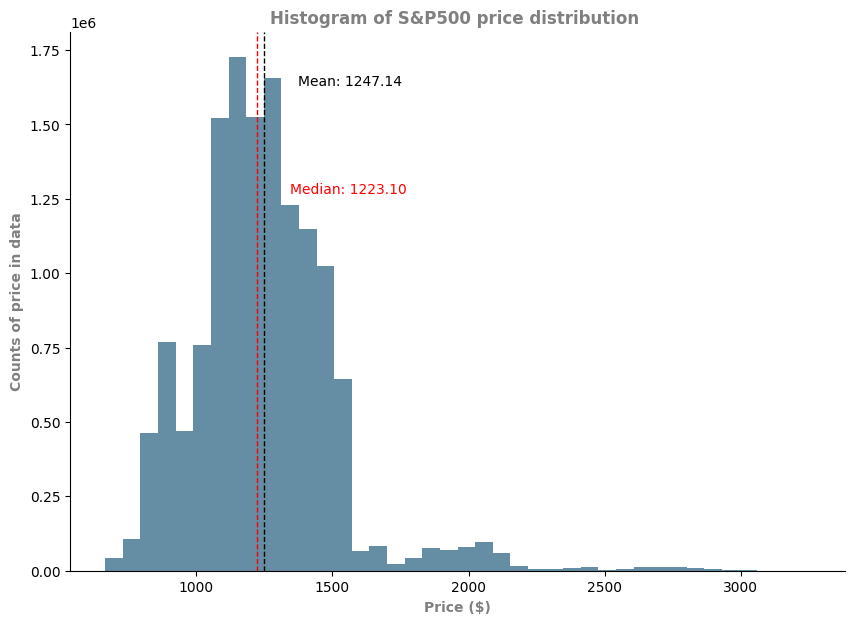

In [9]:
fig, ax = plt.subplots(figsize = (10,7))
ax.hist(df.price, bins=40, color='#658da3')


min_ylim, max_ylim = plt.ylim()

# label mean
plt.axvline(df.price.mean(), color='k', linestyle='dashed', linewidth=1)
plt.text(df.price.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(df.price.mean()))

# label median
plt.axvline(df.price.median(), color='r', linestyle='dashed', linewidth=1)
plt.text(df.price.median()*1.1, max_ylim*0.7, 'Median: {:.2f}'.format(df.price.median()), color='r')

# Graph labels
ax.set_title("Histogram of S&P500 price distribution ",c='grey', weight = 'bold')
ax.set_ylabel('Counts of price in data',c='grey', weight = 'bold')
ax.set_xlabel('Price ($)',c='grey', weight = 'bold')

#hide the frames, only show x and y axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

I will make some augmentation to create columns with the daily average, daily min, daily max, and daily_variance

In [10]:
daily_mean_df = df.groupby('date')['price'].mean().to_frame('daily_avg').reset_index()
daily_max_df = df.groupby('date')['price'].max().to_frame('daily_max').reset_index()
daily_min_df = df.groupby('date')['price'].min().to_frame('daily_min').reset_index()

df = pd.merge(df, daily_mean_df, left_on='date', right_on='date')
df = pd.merge(df, daily_max_df, left_on='date', right_on='date')
df = pd.merge(df, daily_min_df, left_on='date', right_on='date')
df['daily_variance'] = df['daily_max'] - df['daily_min']

In [11]:
df.head()

,date,time,price,volume,daily_avg,daily_max,daily_min,daily_variance
0,2000-01-03,08:30:34,1496.4,0,1464.939479,1496.4,1452.0,44.4
1,2000-01-03,08:30:36,1496.0,0,1464.939479,1496.4,1452.0,44.4
2,2000-01-03,08:30:37,1495.5,0,1464.939479,1496.4,1452.0,44.4
3,2000-01-03,08:30:46,1495.0,0,1464.939479,1496.4,1452.0,44.4
4,2000-01-03,08:30:53,1495.5,0,1464.939479,1496.4,1452.0,44.4


In [12]:
# grouped dataframe by day

grouped_df = df[['date', 'daily_avg', 'daily_max', 'daily_min', 'daily_variance']].drop_duplicates().reset_index(drop=True)
grouped_df.head()

,date,daily_avg,daily_max,daily_min,daily_variance
0,2000-01-03,1464.939479,1496.4,1452.0,44.4
1,2000-01-04,1434.881533,1453.5,1409.5,44.0
2,2000-01-05,1411.066877,1427.5,1387.0,40.5
3,2000-01-06,1416.693848,1425.8,1401.0,24.8
4,2000-01-07,1434.536222,1460.5,1412.0,48.5


Below is a line plot of the daily avg price. There seems to be a dip from 2000 to 2003. Afterwards, there seems to be an upward trend from 2004 to 2007 and a dip in 2008~2009. Lastly, there seems to be a consistent upward trend from 2009 to 2020.

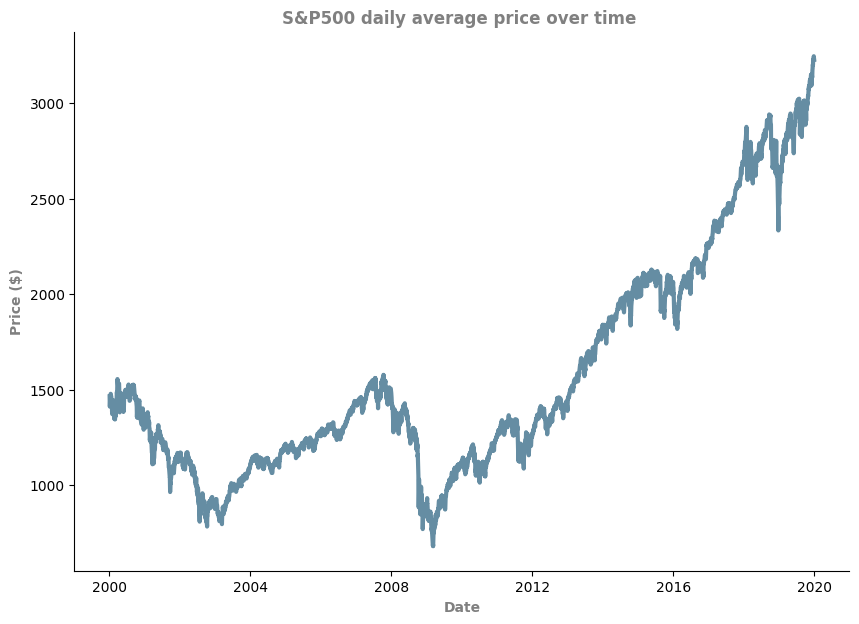

In [13]:
fig, ax = plt.subplots(figsize = (10,7))

ax.plot(grouped_df.date, grouped_df.daily_avg, c='#658da3', lw=3)

# Graph labels
ax.set_title("S&P500 daily average price over time ",c='grey', weight = 'bold')
ax.set_ylabel('Price ($)',c='grey', weight = 'bold')
ax.set_xlabel('Date',c='grey', weight = 'bold')

#hide the frames, only show x and y axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

The minimum variance days seems to be weekends since the market is not open.

In [14]:
grouped_df[grouped_df['daily_variance'] == grouped_df['daily_variance'].min()]

,date,daily_avg,daily_max,daily_min,daily_variance
4955,2016-09-04,2179.2,2179.2,2179.2,0.0
5045,2016-12-18,2257.0,2257.0,2257.0,0.0
5083,2017-02-05,2290.9,2290.9,2290.9,0.0
5095,2017-02-19,2347.4,2347.4,2347.4,0.0
5113,2017-03-12,2366.8,2366.8,2366.8,0.0
5131,2017-04-02,2358.8,2358.8,2358.8,0.0
5350,2017-12-17,2687.5,2687.5,2687.5,0.0
5356,2017-12-25,2686.0,2686.0,2686.0,0.0
5361,2018-01-01,2678.4,2678.4,2678.4,0.0
5372,2018-01-14,2792.0,2792.0,2792.0,0.0


February 5th of 2018 had the highest variance in price with an increase of $229.40 in price

In [15]:
grouped_df[grouped_df['daily_variance'] == grouped_df['daily_variance'].max()]

,date,daily_avg,daily_max,daily_min,daily_variance
5391,2018-02-05,2655.076339,2761.2,2531.8,229.4


Below is a graph of the variance in price throughout the day

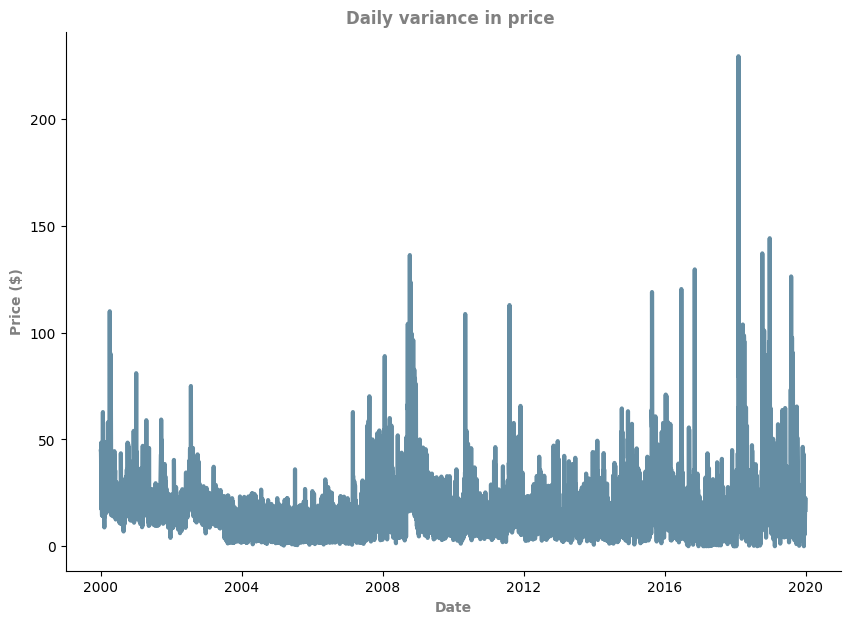

In [16]:
fig, ax = plt.subplots(figsize = (10,7))

ax.plot(grouped_df.date, grouped_df.daily_variance, c='#658da3', lw=3)

# Graph labels
ax.set_title("Daily variance in price ",c='grey', weight = 'bold')
ax.set_ylabel('Price ($)',c='grey', weight = 'bold')
ax.set_xlabel('Date',c='grey', weight = 'bold')

#hide the frames, only show x and y axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

### Export as json for Kafka pipeline

In [17]:
df['date'] = df['date'].astype('str')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13802502 entries, 0 to 13802501
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   time            object 
 2   price           float64
 3   volume          int64  
 4   daily_avg       float64
 5   daily_max       float64
 6   daily_min       float64
 7   daily_variance  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 842.4+ MB


In [ ]:
df.to_json('sp.json', orient="records")